In [16]:

# -*- coding: utf-8 -*-
"""EEP 596 HW2
"""

import numpy as np
import cv2
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

class ComputerVisionAssignment():
  def __init__(self) -> None:
    
    # loading as single-channel uint8
    self.ant_img = cv2.imread('ant_outline.png', cv2.IMREAD_GRAYSCALE)
    self.cat_eye = cv2.imread('cat_eye.jpg', cv2.IMREAD_GRAYSCALE)
    self.blurred_images = []

  def floodfill(self, seed = (0, 0)):

    # seed (x, y) is the starting pixel

    if self.ant_img is None:
        raise ValueError("Image was not loaded!")
    
    height, width = self.ant_img.shape[:2]
    x0, y0 = seed
    if not (0 <= x0 < width and 0 <= y0 < height):
        raise ValueError("Seed is out of bounds!")
    # Define the fill color (e.g., bright green)
    fill_color = (0, 0, 255)  # (B, G, R)
    # get color at the seed to be replaced
    # Create a copy of the input image to keep the original image unchanged
    output_image = self.ant_img.copy()
    target_color = int(output_image[y0, x0])
    output_image = cv2.cvtColor(output_image, cv2.COLOR_GRAY2BGR)

    # Define a stack for floodfill

    # mask to avaoid re doing pixels
    visited = np.zeros((height, width), dtype=np.uint8)
    # LIFO
    stack = [(x0, y0)]

    # 4-conntected neibors (left, right, up, down)
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]


    while stack:
        x, y = stack.pop()
        #print(output_image[y, x])

        if int(self.ant_img[y, x]) == target_color:
            output_image[y, x] = fill_color
            #print(output_image[y, x])
            visited[y, x] = 1

            # push valid neigbors
            for dx, dy in neighbors:
                xn, yn = x + dx, y + dy
                if 0 <= xn < width and 0 <= yn < height and not visited[yn, xn]:
                    stack.append((xn, yn))

    #cv2.imwrite('floodfille.jpg', output_image)
    return output_image
  

  # helper for 1D conv with zero pattern (horizontal loop
  def _conv1d_hort(self, img, k):
      height, width = img.shape
      out = np.zeros((height, width), dtype=np.float32)
      for y in range(height):
        for x in range(width):
          a = img[y, x-1] if x-1 >= 0 else 0
          b = img[y, x]
          c = img[y, x+1] if x+1 < width else 0
          out[y, x] = k[0]*a + k[1]*b + k[2]*c
      return out

  # helper for 1D conv with zero pattern (vert loop
  def _conv1d_vert(self, img, k):
    height, width = img.shape
    out = np.zeros((height, width), dtype=np.float32)
    for y in range(height):
      for x in range(width):
        a = img[y-1, x] if y-1 >= 0 else 0
        b = img[y, x]
        c = img[y+1, x] if y+1 < height else 0
        out[y, x] = k[0]*a + k[1]*b + k[2]*c
    return out


  def gaussian_blur(self):
    """
    Apply Gaussian blur to the image iteratively.
    """

    
    if self.cat_eye is None:
       raise ValueError("Image not loaded!")
    kernel = np.array([1, 2, 1], dtype=np.float32) * 0.25 # 1D Gaussian kernel
    image = self.cat_eye.astype(np.float32)
    
    # 1d gaussian kernel
    for _ in range(5):
      # two passes : hort then vert
      tmp = self._conv1d_hort(image, kernel)
      image = self._conv1d_vert(tmp, kernel)

      # round to nearest, clamp, cast to uint8
      img_uint8 = np.clip(np.rint(image), 0, 255).astype(np.uint8)
      self.blurred_images.append(img_uint8)

      image = img_uint8.astype(np.float32)
      cv2.imwrite(f'gaussain blur {_}.jpg', image)
    return self.blurred_images

  def gaussian_derivative_vertical(self):
    if not getattr(self, "blurred_images", None):
      self.gaussian_blur()

    # 1d kernels
    k_smooth = np.array([1, 2, 1], dtype=np.float32) * 0.25

    k_deriv_v = np.array([1, 0, -1], dtype=np.float32) * 0.5

    self.vDerive_images = []
   # idx = 0
    for img_u8 in self.blurred_images:
       img_f = img_u8.astype(np.float32)

       # seperatble pass
       tmp = self._conv1d_hort(img_f, k_smooth)
       deriv = self._conv1d_vert(tmp, k_deriv_v)

       # clamp --> p_out = clamp(2*p_in + 128)
       mapped = 2.0*deriv + 127.0
       out_uint8 = np.clip(np.rint(mapped), 0, 255).astype(np.uint8)

       self.vDerive_images.append(out_uint8)
       #cv2.imwrite(f'horizontal {idx}.jpg', out_uint8)
       #idx+=1
      
    return self.vDerive_images

  def gaussian_derivative_horizontal(self):
    if not getattr(self, "blurred_images", None):
       self.gaussian_blur()
    #Define kernels
    k_smooth_v = np.array([1, 2, 1], dtype=np.float32) * 0.25 # vert smoothing
    k_deriv_v = np.array([1, 0, -1], dtype=np.float32) * 0.5  # hort. derivative

    # Store images after computing horizontal derivative
    self.hDerive_images = []

    idx = 0
    for img_u8 in self.blurred_images:
       img_f = img_u8.astype(np.float32)

       tmp = self._conv1d_vert(img_f, k_smooth_v)
       deriv = self._conv1d_hort(tmp, k_deriv_v)

       mapped = 2.0*deriv + 127.0
       out_uint8 = np.clip(np.rint(mapped), 0, 225).astype(np.uint8)

       self.hDerive_images.append(out_uint8)
       #cv2.imwrite(f'vertical {idx}.jpg', out_uint8)
       idx+=1


    return self.hDerive_images

  def gradient_magnitute(self):
    # make sure the 5 blurred images exist
    if not getattr(self, "blurred_images", None):
       self.gaussian_blur()

    # kernels
    k_smooth = np.array([1, 2, 1], dtype=np.float32) * 0.25

    k_deriv = np.array([1, 0, -1], dtype=np.float32) * 0.5

    self.gdMagnitute_images = []
    idx = 0
    for img_u8 in self.blurred_images:
       img_f = img_u8.astype(np.float32)

       # gx --> smoothj vertically then hort derivative
       tmp_v = self._conv1d_vert(img_f, k_smooth)
       gx = self._conv1d_hort(tmp_v, k_deriv)
       gx = np.abs(gx)

       # gy --> smmoth nort then vert derivatrive
       tmp_h = self._conv1d_hort(img_f, k_smooth)
       gy = self._conv1d_vert(tmp_h, k_deriv)
       gy = np.abs(gy)

       # manhattan norm, scale x4, clamp, then uint8
       p_in = gx + gy
       mapped = 4.0*p_in
       out_u8 = np.clip(np.rint(mapped), 0, 255).astype(np.uint8)

       self.gdMagnitute_images.append(out_u8)
       #cv2.imwrite(f'gradient {idx}.jpg', out_u8)
       idx += 1
    
    return self.gdMagnitute_images

  def scipy_convolve(self):
    if not getattr(self, "blurred_images"):
       self.gaussian_blur()
    
    k_smooth_h = np.array([1, 2, 1], dtype=np.float32) * 0.25
    k_deriv_v = np.array([1, 0, -1], dtype=np.float32) * 0.5

    self.scipy_smooth = []

    #idx =0 
    for img_u8 in self.blurred_images:
       img_f = img_u8.astype(np.float32)
       # hort smooth then vert derivative
       tmp = convolve2d(img_f, k_smooth_h.reshape(1, 3), mode='same',
                        boundary='fill', fillvalue=0)
       deriv = convolve2d(tmp, k_deriv_v.reshape(3,1), mode='same',
                          boundary='fill', fillvalue=0)
       
       mapped = 2.0 * deriv + 127.0
       out_u8 = np.clip(np.rint(mapped), 0, 255).astype(np.uint8)

       self.scipy_smooth.append(out_u8)
       #cv2.imwrite(f'scipy smooth {idx}.jpg', out_u8)
       #idx+=1

    return self.scipy_smooth
  
  
  def box_filter(self, num_repetitions):
    base = np.array([1, 1, 1], dtype=np.int64)
    
    def conv1d_full(a, b):
      # full con length = len(a) + len(b) - 1
      na, nb = len(a), len(b)
      out = np.zeros(na + nb - 1, dtype=np.int64)

      for i in range(na):
        ai = int(a[i])
        for j in range(nb):
          out[i + j] += ai * int(b[j])
      return out
     
    filt = base.copy()
     
    for _ in range(num_repetitions):
        filt = conv1d_full(filt, base)

    return filt

  def plot_box_filter_gaussianity(self):
    """
    Plot the 1D box filter convolved with itself 0..5 times.
    Imports matplotlib inside to avoid import issues during grading.
    Filters are normalized to sum to 1 for visual comparison.
    """

    # Reuse your box_filter() to generate filters
    filters = [self.box_filter(k) for k in range(6)]  # 0..5 convolutions

    plt.figure(figsize=(8, 4))
    for k, f in enumerate(filters):
        f = f.astype(np.float64)
        f_norm = f / f.sum()  # normalize for shape comparison
        x = np.arange(len(f_norm)) - (len(f_norm) - 1) / 2.0  # center at 0
        plt.plot(x, f_norm, marker='o', linewidth=1, label=f'{k} conv')

    plt.title('Repeated box filtering (approaches Gaussian)')
    plt.xlabel('tap index (centered)')
    plt.ylabel('normalized amplitude')
    plt.legend()
    plt.tight_layout()
    plt.show()
  




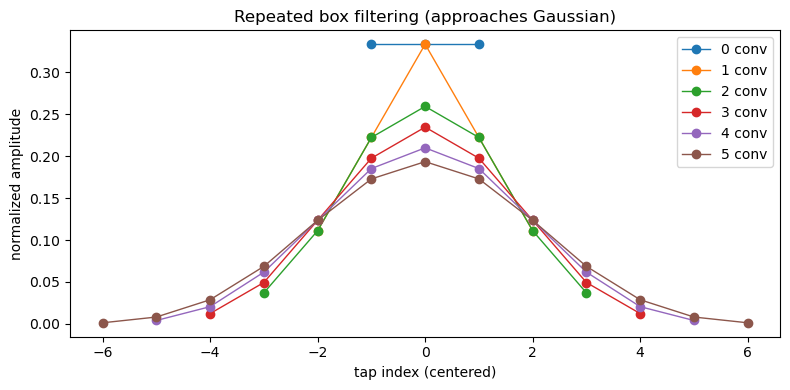

In [17]:
if __name__ == "__main__":
    ass = ComputerVisionAssignment()
    # # Task 1 floodfill
    floodfill_img = ass.floodfill((100, 100))

    # Task 2 Convolution for Gaussian smoothing.
    blurred_imgs = ass.gaussian_blur()

    # Task 3 Convolution for differentiation along the vertical direction
    vertical_derivative = ass.gaussian_derivative_vertical()

    # Task 4 Differentiation along another direction along the horizontal direction
    horizontal_derivative = ass.gaussian_derivative_horizontal()

    # Task 5 Gradient magnitude.
    Gradient_magnitude = ass.gradient_magnitute()

    # Task 6 Built-in convolution
    scipy_convolve = ass.scipy_convolve()

    # Task 7 Repeated box filtering
    box_filter = ass.box_filter(5)
    ass.plot_box_filter_gaussianity()